# SLIC Superpixels

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw

In [ ]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this, we implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, we define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, we check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once we loop through all the clusters, we can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/" 

## Helper Functions:

### Code

In [ ]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []
        self.val = np.array([l,a,b,h,w])

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w
        self.val = np.array([l,a,b,h,w])

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w, img):
    l = cv2.getRectSubPix(img[:,:,0], (1,1), (w,h))[0,0]
    a = cv2.getRectSubPix(img[:,:,1], (1,1), (w,h))[0,0]
    b = cv2.getRectSubPix(img[:,:,2], (1,1), (w,h))[0,0]
    # return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)
    return SuperPixel(l,a,b,h,w)

def display_clusters(img, clusters, use_hsv = False):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels.astype(np.uint64):
            image[p[3],p[4]][0] = c.l
            image[p[3],p[4]][1] = c.a
            image[p[3],p[4]][2] = c.b
        w = int(np.round(c.w))
        h = int(np.round(c.h))
        image[h,w][0] = 0
        image[h,w][1] = 0
        image[h,w][2] = 0
    
    if use_hsv:
      rgb_arr = color.hsv2rgb(image)
    else:
      rgb_arr = color.lab2rgb(image)
    show_image(rgb_arr)
    return rgb_arr


In [ ]:
from matplotlib import axis
import time
# Functions for Simple Linear Iterative Clustering (SLIC)

def initialize_cluster_centers(k, image, img_h, img_w, clusters):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    
    num = int(np.sqrt(k))
    values = []
    w_centers = np.linspace(0, img_w, num+2)[1:-1]
    h_centers = np.linspace(0, img_h, num+2)[1:-1]

    for x in w_centers:
      for y in h_centers:
        c = make_SuperPixel(y,x,image)
        clusters.append(c)
        values.append(c.val)

    return clusters, np.array(values)

def relocate_cluster_center_at_lowgrad(clusters, image, gradient, values):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)

    for i in range(len(clusters)):
      c = clusters[i]

      grad = cv2.getRectSubPix(gradient, (3,3), (c.w,c.h))
      min = np.where(grad == np.min(grad))
      new_w = c.w + min[1][0] - 1
      new_h = c.h + min[0][0] - 1

      l = cv2.getRectSubPix(image[:,:,0], (1,1), (new_w,new_h))[0,0]
      a = cv2.getRectSubPix(image[:,:,1], (1,1), (new_w,new_h))[0,0]
      b = cv2.getRectSubPix(image[:,:,2], (1,1), (new_w,new_h))[0,0]

      c.update(l, a, b, new_h, new_w)
      values[i,:] = np.array([l,a,b,new_h,new_w])

    return clusters, values

def assign_cluster(clusters, S, image, img_h, img_w, pixel_coords, og_values, weights):
    #### Write your code here ####
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.

    dist = np.zeros((pixel_coords.shape[0], len(clusters)))
    met_dist = np.zeros((pixel_coords.shape[0], len(clusters)))

    wts = weights

    values = copy.deepcopy(og_values)

    for i in range(len(clusters)):
      value = values[i,:]
      dist_c = np.linalg.norm(pixel_coords[:,-2:] - value[-2:], axis = 1)
      dist_m = np.linalg.norm(np.multiply(pixel_coords - value, wts), axis = 1)

      dist[:,i] = dist_c
      met_dist[:,i] = dist_m
    
    met_dist[np.where(dist > 2*S)] = 1000000

    cluster_ids = np.argmin(met_dist, axis = 1)

    for i in range(len(clusters)):
      c_pixels = pixel_coords[np.where(cluster_ids == i)]
      clusters[i].pixels = c_pixels

    return clusters

def update_clusters(clusters, image, values):
    #### Write your code here ####
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    for i in range(len(clusters)):
      c = clusters[i]
      [y,x] = np.mean(np.array(c.pixels), axis = 0)[-2:]
      l = cv2.getRectSubPix(image[:,:,0], (1,1), (x,y))[0,0]
      a = cv2.getRectSubPix(image[:,:,1], (1,1), (x,y))[0,0]
      b = cv2.getRectSubPix(image[:,:,2], (1,1), (x,y))[0,0]
      c.update(l,a,b,y,x)
      values[i,:] = np.array([l,a,b,y,x])

    return clusters, values

def compute_res_error(old_values, new_values):
    #### Write your code here ####
    # Computing residual error
    error = np.mean(np.absolute(old_values[:,-2:]-new_values[:,-2:]))
    return error

def assError(clusters):
    # Computing assignment error
    error = 0
    for c in clusters:
      error += np.mean(np.linalg.norm(c.pixels - c.val, axis = 1), axis = 0)
    return error/len(clusters)

def slic_algorithm(k, S, image, img_h, img_w, clusters, weights, disp_error = False, disp_runtime = False):

    # Initialize cluster centers on pixel grid in steps S
    # clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)
    _ , values = initialize_cluster_centers(k, image, img_h, img_w, clusters)

    pixel_coords = []
    for x in range(img_w):
      for y in range(img_h):
        pixel_coords.append([image[y,x,0],image[y,x,1],image[y,x,2],y,x])

    pixel_coords = np.array(pixel_coords)

    # Move centers to position in 3x3 window with smallest gradient.
    kx = np.array([[-1,0,1]])
    ky = np.array([[-1],[0],[1]])
    dx = cv2.filter2D(image, -1, kx)
    dy = cv2.filter2D(image, -1, ky)

    gradient = np.sum(np.sqrt(dx**2 + dy**2), axis=-1)

    _ , values = relocate_cluster_center_at_lowgrad(clusters, image, gradient, values)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value
    threshold = 1 # tune this

    iter = 1
    runtimes = []

    while(iter <= 10):

      st = time.time()

      assign_cluster(clusters, S, image, img_h, img_w, pixel_coords, values, weights)

      if(iter == 1 and disp_error):
        print("Error at initialization = " + str(assError(clusters)))

      old_values = copy.deepcopy(values)

      _ , new_values = update_clusters(clusters, image, values)

      res_err = compute_res_error(old_values, new_values)

      et = time.time()

      values = new_values

      runtimes.append(et-st)

      iter = iter + 1

      if res_err<threshold:
        break

    if disp_error: print("Error at convergence = " + str(assError(clusters)))

    if disp_runtime: print("Avg. runtime per iteration for k = " + str(k) + " is " + str(np.mean(np.array(runtimes)))+ " seconds\n")
    
    return clusters

def runSLIC(img_path, k, weights = np.array([1,1,1,1,1]), display = True, disp_error = False, disp_runtime = False, use_hsv = False):
    # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
    image = img_as_float(io.imread(img_path))

    # convert RGB to LAB
    if use_hsv:
      image = color.rgb2hsv(image)
    else:
      image = color.rgb2lab(image)

    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width

    image = np.float32(image)

    # k: Number of clusters/superpixels.
    k = k

    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel

    clusters = []
    err = []
    clusters = slic_algorithm(k, S, image, img_h, img_w, clusters, weights, disp_error, disp_runtime)
    
    if display:
      SP_img = display_clusters(image, clusters, use_hsv=use_hsv)
      return clusters, SP_img
    
    return clusters

In [ ]:
import skimage.segmentation as seg

def boundaryRecall(GT_path, image, clusters, d = 2):
  # Implementation of the Boundary Recall metric
    labels = np.zeros((image.shape[0], image.shape[1]))
    for i in range(len(clusters)):
      for j in range(clusters[i].pixels.shape[0]):
        labels[int(clusters[i].pixels[j,3]), int(clusters[i].pixels[j,4])] = i

    segmented = seg.mark_boundaries(image.astype(np.uint64), labels.astype(np.uint64))
    segmented = segmented[:,:,0]

    # show_image(segmented)

    GT = scipy.io.loadmat(GT_path)
    GT_boundary = np.zeros(GT['groundTruth'][0,4][0][0][1].shape)

    for i in range(5):
      GT_boundary[GT['groundTruth'][0,i][0][0][1] == 1] = 1

    # show_image(GT_boundary)

    GT_BC = np.argwhere(GT_boundary == 1)

    segmented_BC = np.argwhere(segmented == 1)

    TP = 0

    for i in range(GT_BC.shape[0]):
      dist = np.linalg.norm(segmented_BC - GT_BC[i], axis = 1)
      if np.min(dist) <= 2:
        TP += 1

    boundary_recall = TP/GT_BC.shape[0]

    return boundary_recall

def underSegmentation(GT_path, image, clusters):
  # Implementation of Undersegmentation metric
  
    labels = np.zeros((image.shape[0], image.shape[1]))
    for i in range(len(clusters)):
      for j in range(clusters[i].pixels.shape[0]):
        labels[int(clusters[i].pixels[j,3]), int(clusters[i].pixels[j,4])] = i

    GT = scipy.io.loadmat(GT_path)
    GT_seg = GT['groundTruth'][0,4][0][0][0]
    GT_set = set(GT['groundTruth'][0,4][0][0][0].flatten())

    labels = np.zeros((image.shape[0], image.shape[1]))
    for i in range(len(clusters)):
      for j in range(clusters[i].pixels.shape[0]):
        labels[int(clusters[i].pixels[j,3]), int(clusters[i].pixels[j,4])] = i

    underseg_error = 0

    for i in GT_set:
      err = 0
      args = np.argwhere(GT_seg == i)
      S = args.shape[0]
      lab = labels[args[:,0],args[:,1]]
      unique = set(lab.flatten())
      for j in unique:
        num_in = lab[lab == j].shape[0]
        num_out = clusters[int(j)].pixels.shape[0] - num_in
        min_val = np.min(np.array([num_in, num_out]))
        # err += min_val/S
        err += min_val
      
      underseg_error += err

    underseg_error = underseg_error/(image.shape[0] * image.shape[1])

    return underseg_error

### Write-up



* Explanation of distance function for measuring the similarity between a pixel and cluster in the 5D space :

The 5D distance function is a simple L2 norm. In other words, given a cluster center C with [l_c, a_c, b_c, h_c, w_c] as its 5D vector, and given a pixel P with [l_p, a_p, b_p, h_p, w_p] as its 5D vector, the 5D distance between C and P is given by: 

Dist = np.sqrt( (l_c - l_p)^2 + (a_c - a_p)^2 + (b_c - b_p)^2 + (h_c - h_p)^2 + (w_c - w_p)^2 )

If using a weight for the distance function w = [w1, w2, w3, w4, w5], each ith term inside the np.sqrt() gets multiplied by ith weight value.

Case 1 : w = [1,1,1,1,1] - Equal weights assigned to all 5 features when computing the distance functions which means that it is equally important that the pixel being assigned to a cluster is close to the cluster center C in terms of pixel distance, as the l, a, b values of the pixel being assigned is similar to C's l, a, b values.

Case 2 : w = [10,10,10,1,1] - Higher weights assigned to the l,a,b features when computer the 5D distance function. The implication is that, the l, a, b similarity of the pixel to a cluster C's l, a, b features is more important than how close they are to C in terms of pixel distance. Even in the results it can be clearly seen that the pixels which are not close to the cluster center in terms of pixel distance being assigned to the cluster since they are similar to C in terms of the l, a, b feature distance.

Case 3 : w = [1,1,1,10,10] - Higher weights assigned to the h, w features when computing the 5D distance. It tries to assign pixels to a cluster which are closer to C in terms of pixel distance, and gives less importance to whether they are similar to C in terms of l, a, b features. As seen in the output, it assigns all the pixels which are closer to the cluster centers to the clusters.
 

In [ ]:
img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"


Case 1 : Using weights w = [1,1,1,1,1]



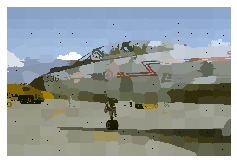

In [ ]:
weights1 = np.array([1,1,1,1,1])
print("\nCase 1 : Using weights w = [1,1,1,1,1]\n")
clusters, SP_img = runSLIC(img_path, 256, weights1)


Using weights w = [10,10,10,1,1]



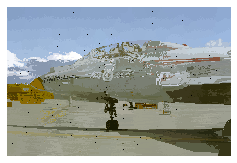

In [ ]:
weights2 = np.array([10,10,10,1,1])
print("\nCase 2 : Using weights w = [10,10,10,1,1]\n")
clusters, SP_img = runSLIC(img_path, 256, weights2)


Case 3 : Using weights w = [1,1,1,10,10]



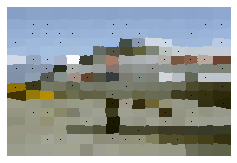

In [ ]:
weights3 = np.array([1,1,1,10,10])
print("\nCase 3 : Using weights w = [1,1,1,10,10]\n")
clusters, SP_img = runSLIC(img_path, 256, weights3)

* c) Showing the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.


The error for question (c) is computed as the average 5D distance of pixels belonging to a cluster from its cluster center C, averaged over all the clusters. (Refer to assError for more information) This error is 'not' the error which is used to threshold and break the loop in which SLIC algorithm runs. 

Error at initialization = 24.552139222043476
Error at convergence = 23.02813161956496


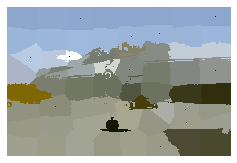

In [ ]:
img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

clusters, SP_img = runSLIC(img_path, 64, disp_error = True)

* d) Showing three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.



Implementing SLIC for k = 64

Avg. runtime per iteration for k = 64 is 2.092730760574341 seconds



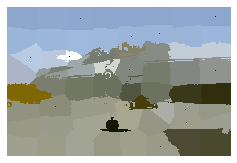


Implementing SLIC for k = 256

Avg. runtime per iteration for k = 256 is 8.411689758300781 seconds



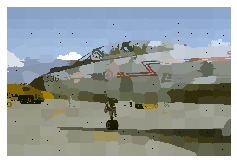


Implementing SLIC for k = 1024

Avg. runtime per iteration for k = 1024 is 35.76810956001282 seconds



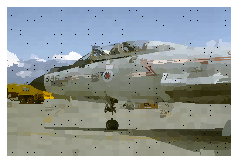

In [ ]:
img_path = "/content/Part1_SLIC/BSD_data/images/10081.jpg"

K = [64, 256, 1024]

for k in K:
  print("\nImplementing SLIC for k = " + str(k) + "\n")
  clusters, SP_img = runSLIC(img_path, k, disp_runtime = True)

* Running the algorithm on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and reporting average run-time per image for the BSD.


Image ID = 10081

Using k = 64

Avg. runtime per iteration for k = 64 is 2.236445109049479 seconds



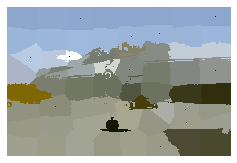


Boundary recall = 0.5898255813953488


Undersegmentation error = 0.19699354278793532


Image ID = 10081

Using k = 256

Avg. runtime per iteration for k = 256 is 8.013207912445068 seconds



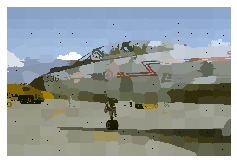


Boundary recall = 0.8388081395348838


Undersegmentation error = 0.09040096890564181


Image ID = 10081

Using k = 1024

Avg. runtime per iteration for k = 1024 is 35.69195103645325 seconds



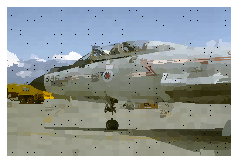


Boundary recall = 0.9575581395348837


Undersegmentation error = 0.06344518494051204


Image ID = 14085

Using k = 64

Avg. runtime per iteration for k = 64 is 2.0293084250556097 seconds



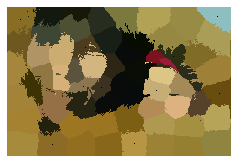


Boundary recall = 0.4283204840441105


Undersegmentation error = 0.26864463313061443


Image ID = 14085

Using k = 256

Avg. runtime per iteration for k = 256 is 8.124147295951843 seconds



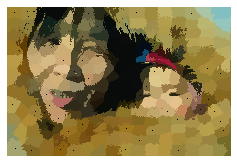


Boundary recall = 0.7156240850980775


Undersegmentation error = 0.1713136572949657


Image ID = 14085

Using k = 1024

Avg. runtime per iteration for k = 1024 is 33.30191779136658 seconds



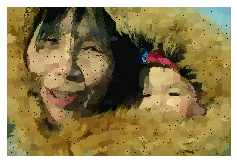


Boundary recall = 0.9204645262027911


Undersegmentation error = 0.11653421933795766


Image ID = 14092

Using k = 64

Avg. runtime per iteration for k = 64 is 2.062756836414337 seconds



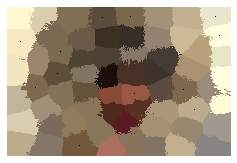


Boundary recall = 0.27203647416413373


Undersegmentation error = 0.20555566349958873


Image ID = 14092

Using k = 256

Avg. runtime per iteration for k = 256 is 8.351984143257141 seconds



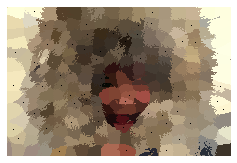


Boundary recall = 0.602773556231003


Undersegmentation error = 0.10014831510158613


Image ID = 14092

Using k = 1024

Avg. runtime per iteration for k = 1024 is 35.45489692687988 seconds



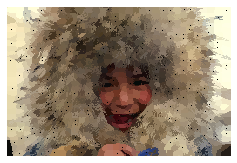


Boundary recall = 0.8803191489361702


Undersegmentation error = 0.05867837643538578


Image ID = 15011

Using k = 64

Avg. runtime per iteration for k = 64 is 2.082902113596598 seconds



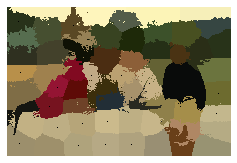


Boundary recall = 0.6333464412111679


Undersegmentation error = 0.2571226870292291


Image ID = 15011

Using k = 256

Avg. runtime per iteration for k = 256 is 9.378916561603546 seconds



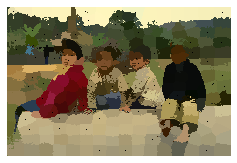


Boundary recall = 0.8394022807707432


Undersegmentation error = 0.12692922973296805


Image ID = 15011

Using k = 1024

Avg. runtime per iteration for k = 1024 is 35.20404541492462 seconds



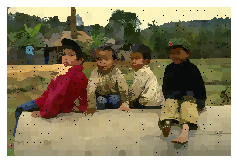


Boundary recall = 0.9634290208415257


Undersegmentation error = 0.08443598163224332


Image ID = 15062

Using k = 64

Avg. runtime per iteration for k = 64 is 2.076693558692932 seconds



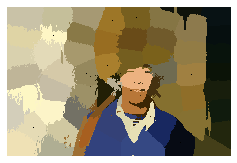


Boundary recall = 0.5252664145754555


Undersegmentation error = 0.24694788246190116


Image ID = 15062

Using k = 256

Avg. runtime per iteration for k = 256 is 8.203914086023966 seconds



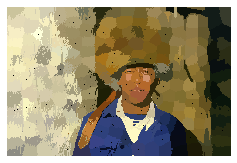


Boundary recall = 0.7506588747565028


Undersegmentation error = 0.10240866315632671


Image ID = 15062

Using k = 1024

Avg. runtime per iteration for k = 1024 is 34.814170479774475 seconds



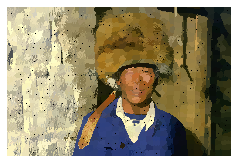


Boundary recall = 0.9294144608685688


Undersegmentation error = 0.0528105387918472


Image ID = 16004

Using k = 64

Avg. runtime per iteration for k = 64 is 2.1209054946899415 seconds



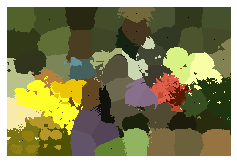


Boundary recall = 0.6183239253148067


Undersegmentation error = 0.24962921224603468


Image ID = 16004

Using k = 256

Avg. runtime per iteration for k = 256 is 7.7314047574996945 seconds



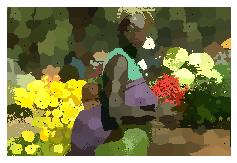


Boundary recall = 0.8208423795049935


Undersegmentation error = 0.16711679328501758


Image ID = 16004

Using k = 1024

Avg. runtime per iteration for k = 1024 is 36.05503296852112 seconds



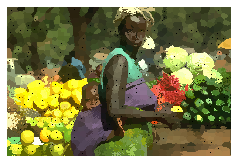


Boundary recall = 0.9457229700390795


Undersegmentation error = 0.08495411299149618


Image ID = 17067

Using k = 64

Avg. runtime per iteration for k = 64 is 2.003824329376221 seconds



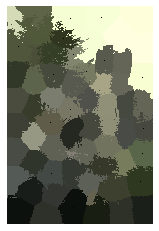


Boundary recall = 0.48534201954397393


Undersegmentation error = 0.31913653408980514


Image ID = 17067

Using k = 256

Avg. runtime per iteration for k = 256 is 7.8327683210372925 seconds



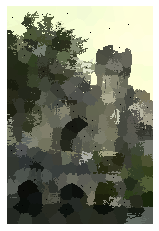


Boundary recall = 0.8064090148780703


Undersegmentation error = 0.1618253767786478


Image ID = 17067

Using k = 1024

Avg. runtime per iteration for k = 1024 is 36.06586158275604 seconds



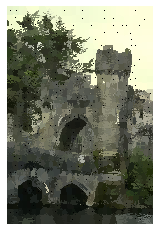


Boundary recall = 0.9562461484285588


Undersegmentation error = 0.11248631809379472


Image ID = 20069

Using k = 64

Avg. runtime per iteration for k = 64 is 2.0455718437830606 seconds



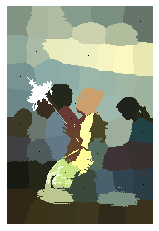


Boundary recall = 0.5631515151515152


Undersegmentation error = 0.16867118736277614


Image ID = 20069

Using k = 256

Avg. runtime per iteration for k = 256 is 7.705353498458862 seconds



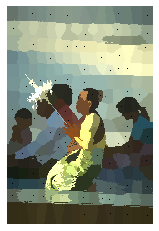


Boundary recall = 0.7791515151515152


Undersegmentation error = 0.05344524970693195


Image ID = 20069

Using k = 1024

Avg. runtime per iteration for k = 1024 is 35.42153835296631 seconds



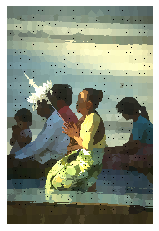


Boundary recall = 0.9231515151515152


Undersegmentation error = 0.034947960181605044


Image ID = 2018

Using k = 64

Avg. runtime per iteration for k = 64 is 2.214636039733887 seconds



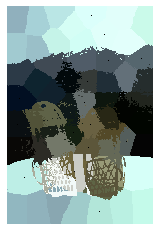


Boundary recall = 0.6839418924224578


Undersegmentation error = 0.20607379485884159


Image ID = 2018

Using k = 256

Avg. runtime per iteration for k = 256 is 7.590344429016113 seconds



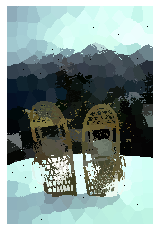


Boundary recall = 0.8773066352571653


Undersegmentation error = 0.1400509064060466


Image ID = 2018

Using k = 1024

Avg. runtime per iteration for k = 1024 is 34.76114308834076 seconds



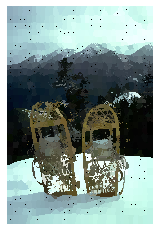


Boundary recall = 0.961523360816647


Undersegmentation error = 0.08525203852306656


Image ID = 23050

Using k = 64

Avg. runtime per iteration for k = 64 is 2.0710299015045166 seconds



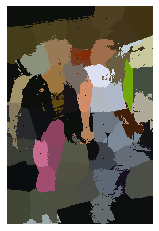


Boundary recall = 0.5918404683497988


Undersegmentation error = 0.41834573610274545


Image ID = 23050

Using k = 256

Avg. runtime per iteration for k = 256 is 8.250465737448799 seconds



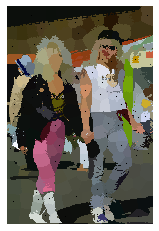


Boundary recall = 0.8724844493230882


Undersegmentation error = 0.18494051204331577


Image ID = 23050

Using k = 1024

Avg. runtime per iteration for k = 1024 is 36.275853633880615 seconds



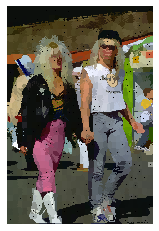


Boundary recall = 0.9501768508354678


Undersegmentation error = 0.1146818997286287



In [ ]:
img_list = ["10081" , "14085", "14092", "15011", "15062", "16004", "17067", "20069", "2018", "23050"]
K = [64, 256, 1024]

for id in img_list:
  for k in K:
    print("\nImage ID = " + id + "\n")
    print("Using k = " + str(k) + "\n")

    img_path = "/content/Part1_SLIC/BSD_data/images/" + id + ".jpg"
    clusters, SP_img = runSLIC(img_path, k, disp_runtime = True)

    GT_path = '/content/Part1_SLIC/BSD_data/groundTruth/test/' + id + '.mat'
    boundary_recall = boundaryRecall(GT_path, SP_img, clusters)
    underseg_error = underSegmentation(GT_path, SP_img, clusters)

    print("\nBoundary recall = " + str(boundary_recall) + "\n")
    print("\nUndersegmentation error = " + str(underseg_error) + "\n")

Original results for k = 256

Avg. runtime per iteration for k = 256 is 8.318627754847208 seconds



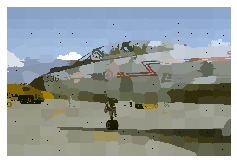


Boundary recall = 0.8388081395348838


Undersegmentation error = 0.09040096890564181



In [ ]:
id = "10081"
k = 256

img_path = "/content/Part1_SLIC/BSD_data/images/" + id + ".jpg"
clusters, SP_img = runSLIC(img_path, k, disp_runtime = True, weights = np.array([1,1,1,1,1]))

GT_path = '/content/Part1_SLIC/BSD_data/groundTruth/test/' + id + '.mat'
boundary_recall = boundaryRecall(GT_path, SP_img, clusters)
underseg_error = underSegmentation(GT_path, SP_img, clusters)

print("\nBoundary recall = " + str(boundary_recall) + "\n")
print("\nUndersegmentation error = " + str(underseg_error) + "\n")

1st method of improvement - Adjusting weights given to the pixel distance when computing the 5D distance and assigning pixels to clusters. Followed the method given in https://www.mdpi.com/2076-3417/9/5/906/htm, which suggests using a value of m/S where S is the average size of super pixel and m is a tunable parameter in the range (1,20). Here a value of m = 7 has been used. This results in a better boundary recall score, however the undersegmentation error does not show any significant improvement, in fact, the error increases by a bit.

Avg. runtime per iteration for k = 256 is 12.269531941413879 seconds



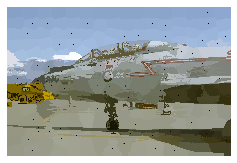


Boundary recall = 0.948110465116279


Undersegmentation error = 0.11339952461447789



In [ ]:
id = "10081"
k = 256

img_path = "/content/Part1_SLIC/BSD_data/images/" + id + ".jpg"

image = img_as_float(io.imread(img_path))

N = image.shape[0]*image.shape[1]

S = int(math.sqrt(N/k))

m = 7

w = m/S

clusters, SP_img = runSLIC(img_path, k, disp_runtime = True, weights = np.array([1,1,1,w,w]))

GT_path = '/content/Part1_SLIC/BSD_data/groundTruth/test/' + id + '.mat'
boundary_recall = boundaryRecall(GT_path, SP_img, clusters)
underseg_error = underSegmentation(GT_path, SP_img, clusters)

print("\nBoundary recall = " + str(boundary_recall) + "\n")
print("\nUndersegmentation error = " + str(underseg_error) + "\n")

2nd method of improvement - The 5D distance was calculated in the hsv space, hence the parameters being [h,s,v,x,y]. Upon a bit of tuning of the weights to individual distance metric, I could achieve a better boundary score when compared to the previous case. However the Undersegmentation error shows a similar trend, it becomes a bit worse when compared to the original case, but better than the previous case.

Avg. runtime per iteration for k = 256 is 11.25001757144928 seconds



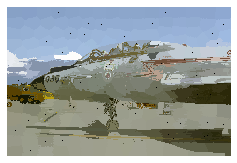


Boundary recall = 0.9488372093023256


Undersegmentation error = 0.1104332225827553



In [ ]:
id = "10081"
k = 256

image = img_as_float(io.imread(img_path))

N = image.shape[0]*image.shape[1]

S = int(math.sqrt(N/k))

m = 0.1

w = m/S

img_path = "/content/Part1_SLIC/BSD_data/images/" + id + ".jpg"
clusters, SP_img = runSLIC(img_path, k, disp_runtime = True, weights = np.array([1,1,1,w,w]), use_hsv=True)

GT_path = '/content/Part1_SLIC/BSD_data/groundTruth/test/' + id + '.mat'
boundary_recall = boundaryRecall(GT_path, SP_img, clusters)
underseg_error = underSegmentation(GT_path, SP_img, clusters)

print("\nBoundary recall = " + str(boundary_recall) + "\n")
print("\nUndersegmentation error = " + str(underseg_error) + "\n")